In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

## Table of Contents
- [Timeseries Comparison](#comparison)

<a class="anchor" id="comparison"></a>
### Timeseries Comparison 
Comparison between item timeseries and centroid of region timeseries

We have choices to either compute correlation between subjects and aggregated emotions or group level and aggregated emotions. We as well introduce other movies for the same subject in order to do permutation testing.

In [2]:
# 1. Loading Gradient Example
networks = list(index2region.keys())
moviename = 'Sintel'
# opt1: Loading Individual Gradient 
# tmp = load('./resources/dynamic_grad/individual_level/Chatter_grad.pkl')
# G_movie, varM = tmp['S30']

# opt2: Loading Group Gradient
G_movie, varM = load('./resources/dynamic_grad/group_level/{}_40_grad.pkl'.format(moviename))

# 2. Loading Matching Emotion Track
full_df  = pd.read_csv('./data/emoFiles/emotion_compile.csv')
emo_df   = full_df[full_df['filename']=='W_{}13.csv'.format(moviename)]
other_df = full_df[full_df['filename']!='W_{}13.csv'.format(moviename)]

We use the following 4 metrics:
- network variance/position
- network volume
- intra-network distances
- explained variance from eigendecomposition

Text(0.5, 0.98, 'Metrics evaluations')

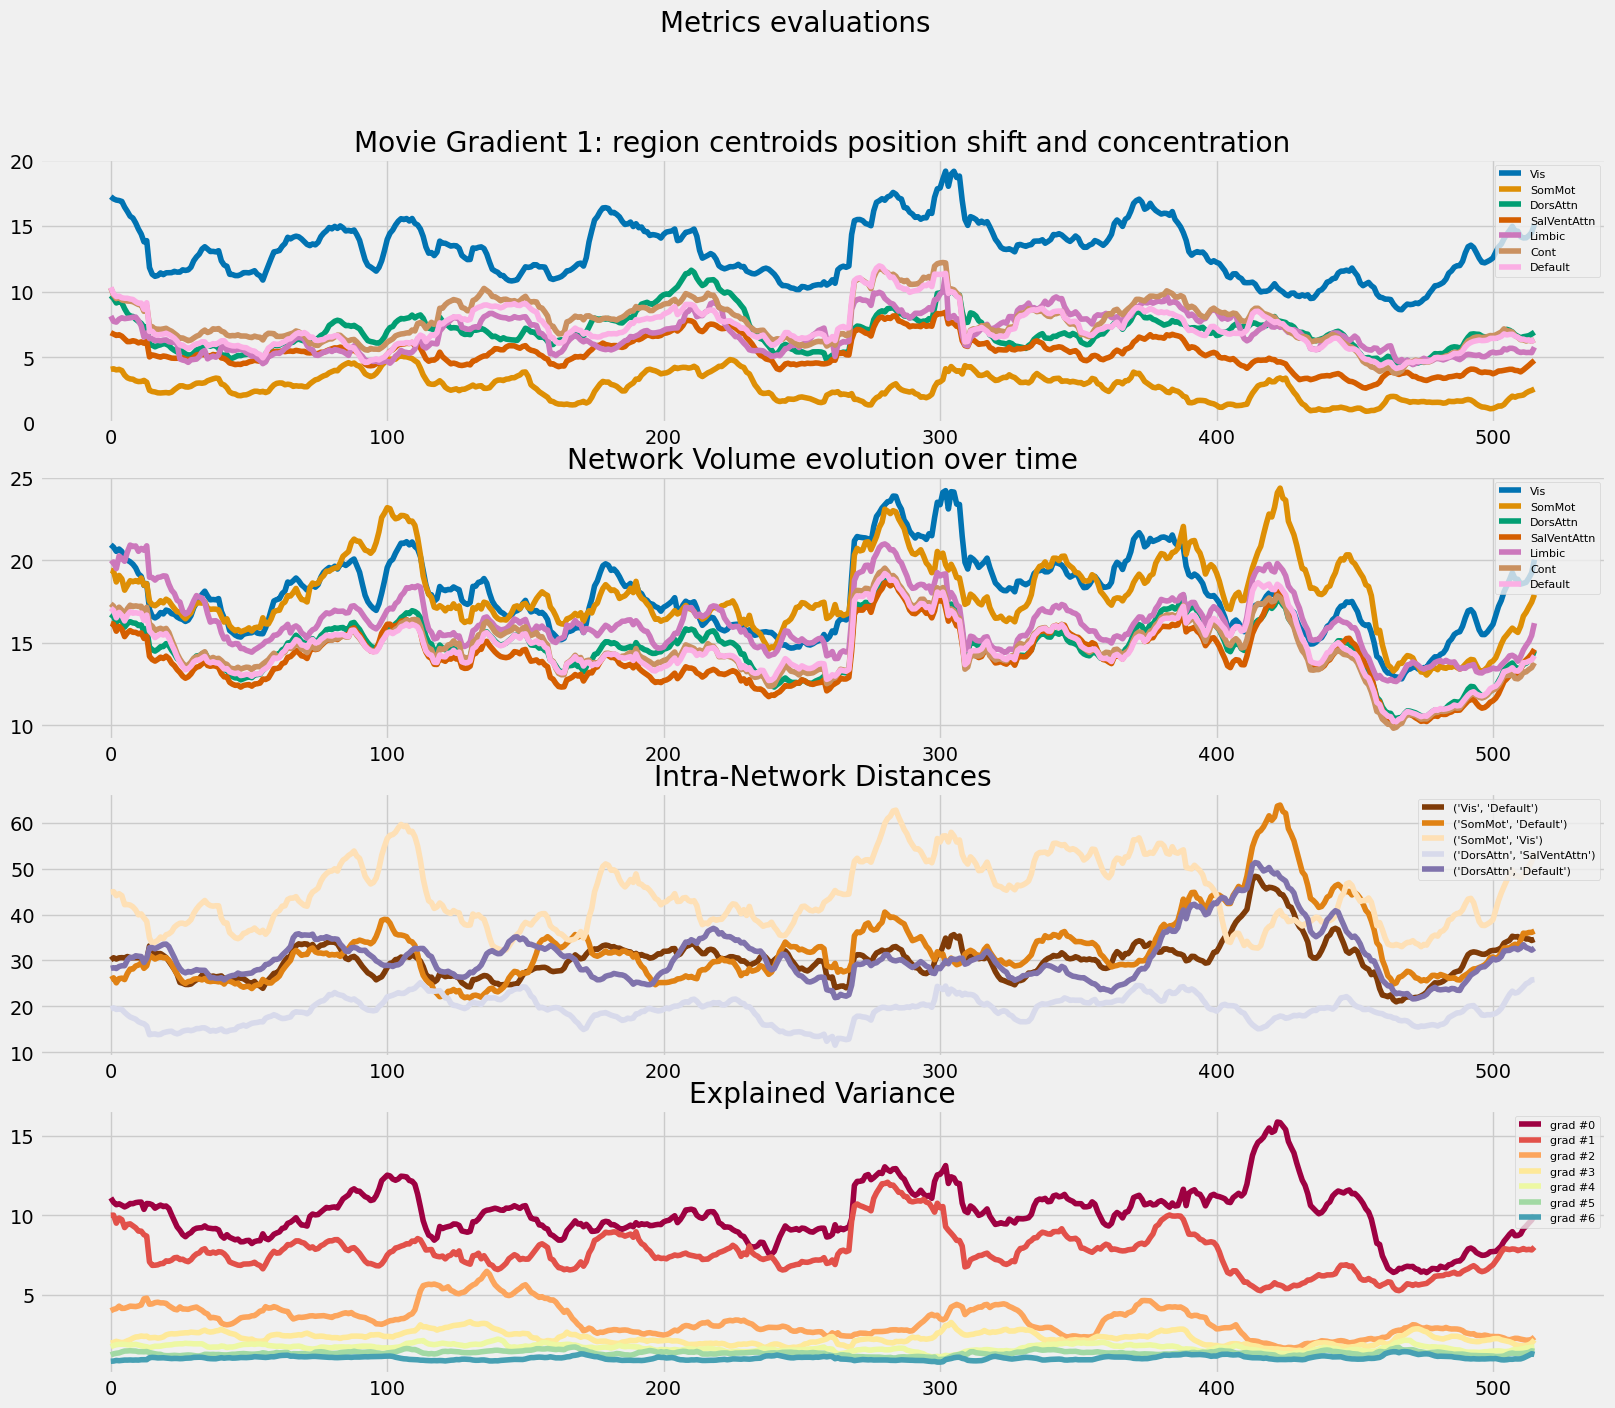

In [4]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)

fig, ax = plt.subplots(4,1,figsize=(18,15))

# METRIC 1
nb = len(networks)
grad_idx = 0
for idx, R in enumerate(networks):
    y = network_position(G_movie, R, grad_idx)
    x = np.arange(len(y))
    error = network_variance(G_movie, R, grad_idx)
    ax[0].plot(x,y, label=R, color=my_cmap.colors[idx])
    # ax[0].fill_between(x, y-error, y+error, alpha=0.4)
    ax[0].legend(loc=1, prop={'size':8})    
# ax[0].axvline(x=wash, label='after wash')
ax[0].set_title("Movie Gradient {}: region centroids position shift and concentration".format(grad_idx + 1))

# METRIC 2
nb = len(networks)
for idx, R in enumerate(networks):
    y = np.asarray([network_volume(G_movie[t], R) 
                    for t in range(len(G_movie))])
    x = np.arange(len(y))

    ax[1].plot(x,y, label=R, color=my_cmap.colors[idx])
    ax[1].legend(loc=1, prop={'size':8})    
ax[1].set_title("Network Volume evolution over time")

# METRIC 3
pairs = [("Vis", "Default"), ("SomMot", "Default"), 
        ("SomMot", "Vis"), ("DorsAttn", "SalVentAttn"),
        ("DorsAttn", "Default")]
nb = len(pairs)
cm = plt.get_cmap('PuOr')
ax[2].set_prop_cycle(color=[cm(1.*i/nb) for i in range(nb)])
for idx, pair in enumerate(pairs):
    p1,p2 = pair
    y = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                    for t in range(len(G_movie))])
    x = np.arange(len(y))
    ax[2].plot(x,y, label=pair)
    ax[2].legend(loc=1, prop={'size':8}) 
ax[2].set_title("Intra-Network Distances")   

# METRIC 4
nb = varM.shape[1]-3
cm = plt.get_cmap('Spectral')
ax[3].set_prop_cycle(color=[cm(1.*i/nb) for i in range(nb)])
for idx, gradnb in enumerate(range(varM.shape[1]-3)):
    y = varM[:,gradnb]
    x = np.arange(len(y))
    ax[3].plot(x,y, label='grad #{}'.format(gradnb))
    ax[3].legend(loc=1, prop={'size':8}) 
ax[3].set_title("Explained Variance") 

plt.suptitle("Metrics evaluations".format(grad_idx + 1), size=20)

Text(0.5, 1.0, 'Aggregated Emotion time series')

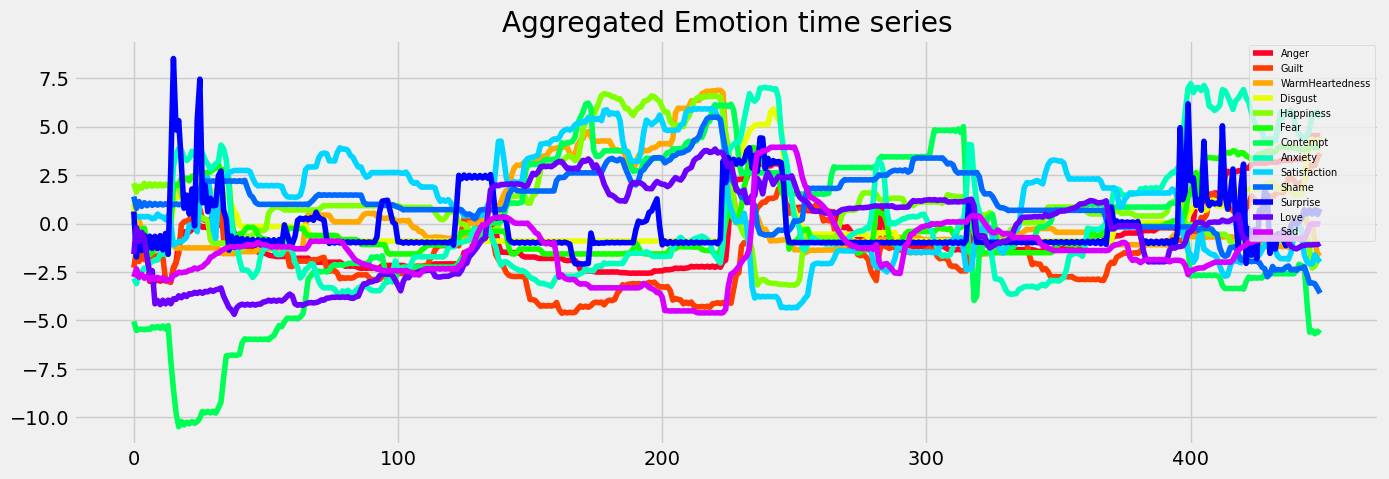

In [5]:
select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Contempt','Anxiety', \
             'Satisfaction','Shame','Surprise','Love','Sad']

NUM_COLORS = len(select)
cm = plt.get_cmap('gist_rainbow')
fig,ax = plt.subplots(1,1, figsize=(15,5))
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for emotion in select:
    emo_series = np.array(emo_df[emo_df.item==emotion]['score'])[:450]
    ax.plot(emo_series, label=emotion)

ax.legend(loc=1, prop={'size':7})
ax.set_title("Aggregated Emotion time series")

Compute correlation between a given metric and emotion series

In [7]:
# Grid for each network of correlation with emotions
grad_idx = 0
smfactor = 1
tolshift = 0


n = len(networks)
m = len(select)

pairs = [("Vis", "Default"), ("SomMot", "Default"), 
        ("SomMot", "Vis"), ("DorsAttn", "SalVentAttn"),
        ("DorsAttn", "Default"), ("Limbic", "Default"), ("Cont", "Default")]
nb_metric = 4
scores  = np.zeros((nb_metric, n,m))
nscores = np.zeros((nb_metric, n,m))

# METRIC 1
for idx, pair in enumerate(tqdm(pairs)):
    p1,p2 = pair
    y = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                    for t in range(len(G_movie))])
    z1 = zscore(y)
    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nscores[0, idx,jdx] = nscore
        scores[0, idx,jdx]  = corr           

# METRIC 2
for idx, R in enumerate(networks):
    y  = network_variance(G_movie, R, grad_idx)
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nscores[1, idx,jdx] = nscore
        scores[1, idx,jdx]  = corr        
    
# METRIC 3
for idx, R in enumerate(networks):
    y  = np.asarray([network_volume(G_movie[t], R) 
                    for t in range(len(G_movie))])
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nscores[2, idx,jdx] = nscore
        scores[2, idx,jdx]  = corr

# METRIC 4
for idx, R in enumerate(networks):
    y  = varM[:,idx]
    z1 = zscore(y)

    for jdx, emotion in enumerate(select):
        concat_other = np.array(other_df[other_df.item == emotion]['score'])
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
        nscores[3, idx,jdx] = nscore
        scores[3, idx,jdx]  = corr


100%|██████████| 7/7 [04:04<00:00, 34.99s/it]


In [8]:
# For each region generate correlation with emotions
smfactor = 1
tolshift = 0

n = G_movie.shape[1]
m = len(select)

scores2 = np.zeros((n,m))

for idx in tqdm(range(n)):
    # Metric we use here is movement of point on the manifold
    tmpA = G_movie[:, idx][:-1]
    tmpB = G_movie[:, idx][1:]

    y    = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") 
            for pidx in range(len(tmpA))])
    z1   = zscore(y)

    for jdx, emotion in enumerate(select):
        emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])

        corr = correlation_search(z1,z2, tolshift)
        scores2[idx,jdx] = corr

100%|██████████| 400/400 [00:14<00:00, 27.47it/s]


#### Correlation brain maps with 7 networks
We select here the max and visualize how well they correlate each other

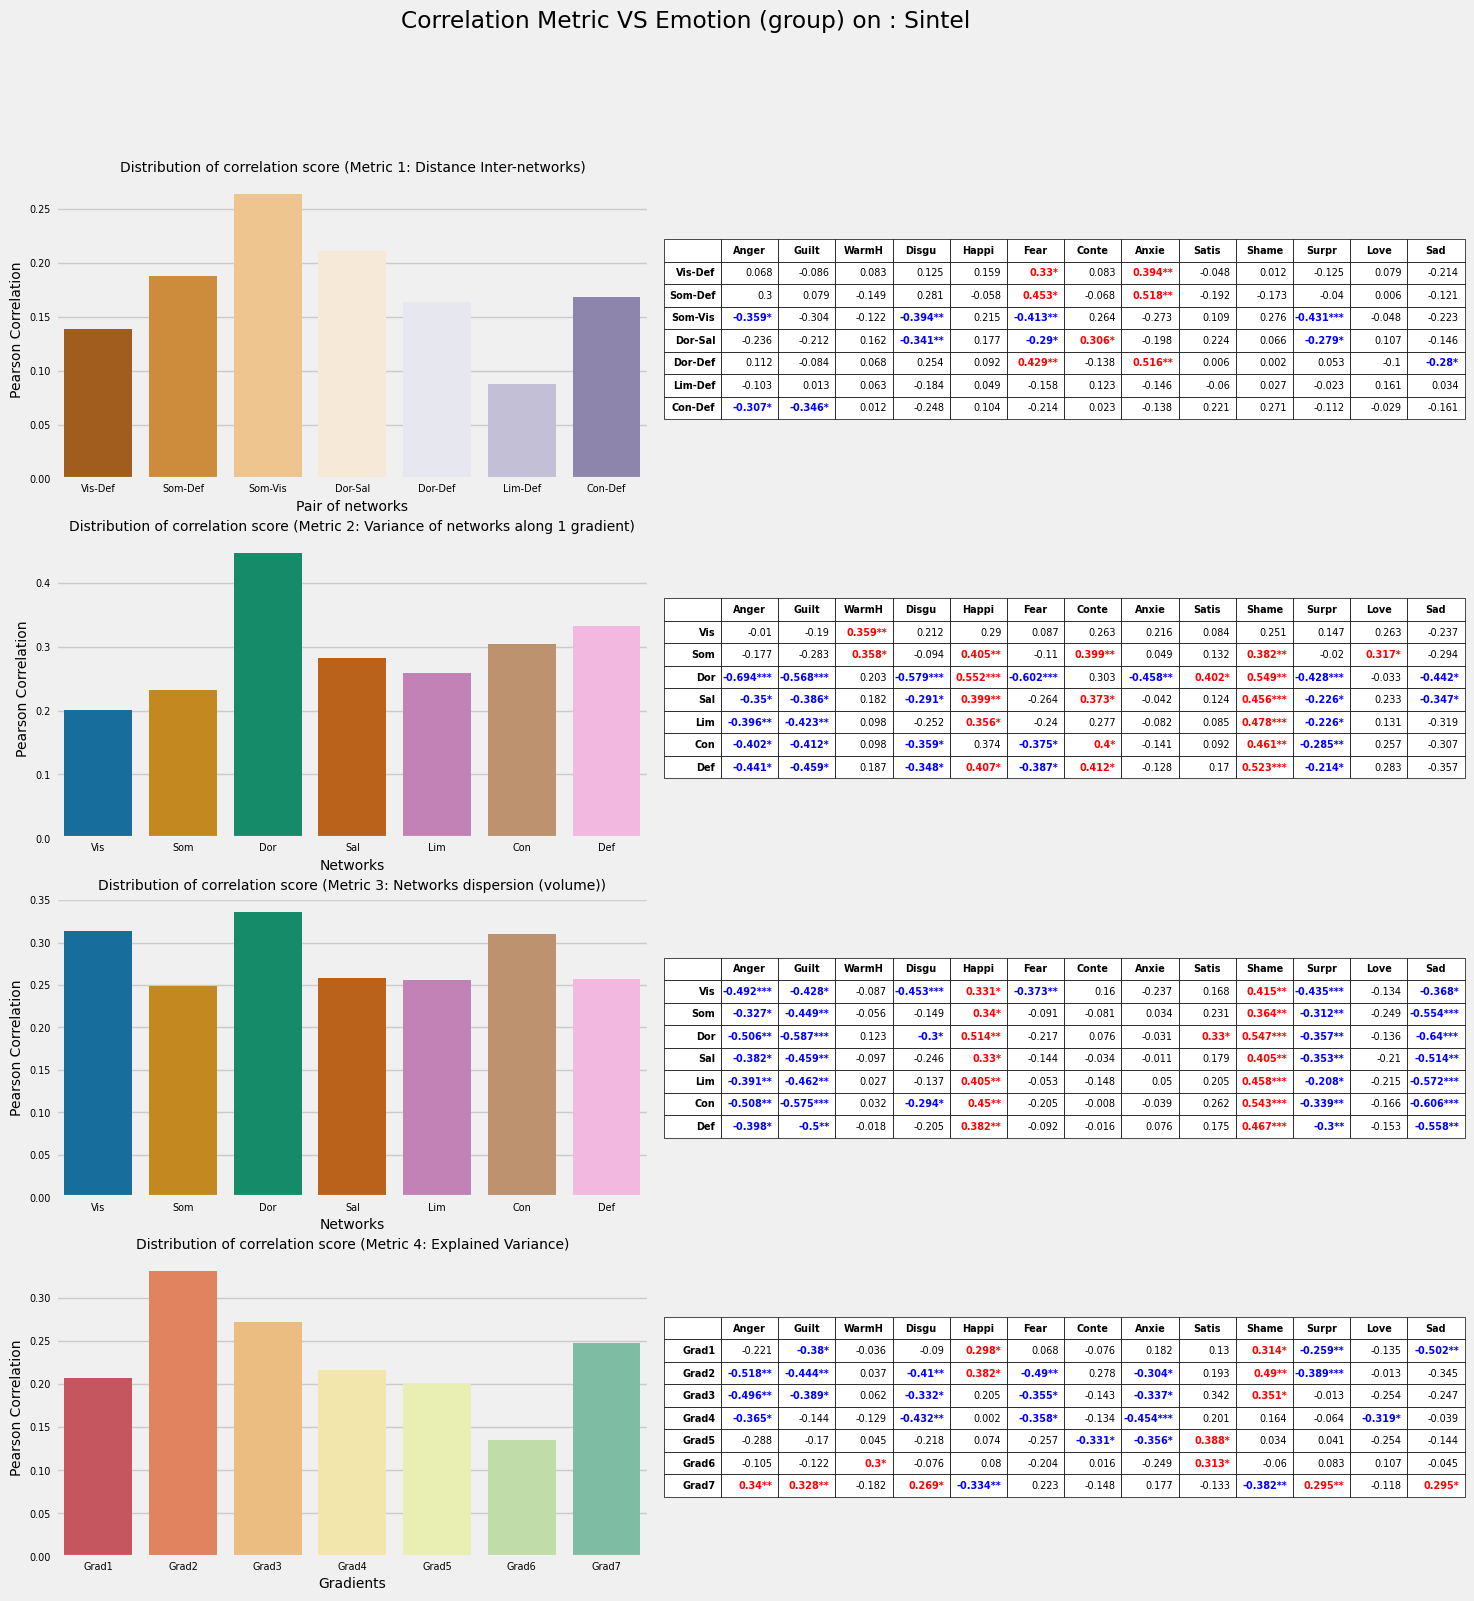

In [9]:
from matplotlib.font_manager import FontProperties

xlabels = ["Pair of networks", "Networks", "Networks", "Gradients"]
titles  = ["Distribution of correlation score (Metric 1: Distance Inter-networks)",
            "Distribution of correlation score (Metric 2: Variance of networks along 1 gradient)",
            "Distribution of correlation score (Metric 3: Networks dispersion (volume))",
            "Distribution of correlation score (Metric 4: Explained Variance)"]


PALETTES = ['PuOr', 'colorblind', 'colorblind', 'Spectral']
fig,ax = plt.subplots(nb_metric,2,figsize=(15,17))
for m in range(nb_metric):
    pal = sns.color_palette(PALETTES[m], 8)
    # MAKING TABLE
    tabling = np.empty((7,14), dtype=np.object_)
    for j in range(14):
        for i in range(7):
            if j == 0:
                if m == 0:
                    p1,p2 = pairs[i] 
                    tabling[i,j] = p1[:3] + '-' + p2[:3]
                elif m == 3:
                    tabling[i,j] = 'Grad{}'.format(i+1)
                else:
                    tabling[i,j] = networks[i][:3]
            else:
                tabling[i,j] = np.object_(np.round(scores[m][i,j-1],3))

    concat_region = np.concatenate([[r] * scores[m].shape[1] for r in tabling[:,0]])
    corr_score = {'networks': concat_region, 'mean-corr': np.abs(scores[m].flatten())}

    sns.barplot(ax=ax[m,0], x="networks", y="mean-corr", data=corr_score, palette=pal, errorbar=None)
    # sns.barplot(ax=ax[m,0], x="networks", y="mean-corr", data=corr_score, capsize=.1, errorbar="sd")
    # sns.swarmplot(ax=ax[m,0], x="networks", y="mean-corr", data=corr_score, color="r", alpha=.65)
    ax[m,0].set_title(titles[m], size=10)
    ax[m,0].tick_params(labelsize=7)
    ax[m,0].set_xlabel(xlabels[m], size=10)
    ax[m,0].set_ylabel('Pearson Correlation', size=10)

    ax[m,1].axis('tight')
    ax[m,1].axis('off')

    table = ax[m,1].table(cellText=tabling,
                            colLabels=[''] + [s[:5] for s in select],
                            loc='center')

    for (row, col), cell in table.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
        if (col == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
            
        # stress on which value is significant against null distribution
        nscore  = nscores[m, row-1, col - 1]
        nbstars = int(nscore < 0.01) + int(nscore < 0.05) + int(nscore < 0.1)
        
        if row != 0 and col !=0 :
            cell.get_text().set_text(str(tabling[row-1,col]) + '*' * nbstars)
            if nbstars > 0:
                cell.set_text_props(fontproperties=FontProperties(weight='bold'))
                if tabling[row-1,col] > 0:
                    cell.get_text().set_color('red')
                else:
                    cell.get_text().set_color('blue')


    
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1.35, 1.35)  # may help                        

plt.suptitle("Correlation Metric VS Emotion (group) on : {}".format(moviename))
plt.show()

Example of null distribution: special sample (i.e we check the correlation of metrics and completely different movies)

In [10]:
# Compute metrics
tmp_emo = 'Anxiety'
net     = 'Limbic'

y  = np.asarray([network_volume(G_movie[t], net) 
                    for t in range(len(G_movie))])

In [11]:
# Compute Correlation with different movies
cur_emo = other_df[other_df.item == tmp_emo]
z1 = zscore(y)
tmp_corr = []
for f in cur_emo.filename.unique():
    tmp = np.array(cur_emo[cur_emo.filename == f]['score'])
    z2  = zscore(tmp)
    if z1.shape[0] < z2.shape[0]:
        diff = z2.shape[0] - z1.shape[0]
        tocompare = np.pad(z1, diff)[diff:]
        tmp_corr.append(correlation_search(tocompare, z2, 0, False))
    else:
        m = min(z1.shape[0], z2.shape[0])
        tmp_corr.append(correlation_search(z1[:m], z2[:m], 0, False))

best_matchmovie = cur_emo.filename.unique()[np.argmax(tmp_corr)]

Text(0.5, 1.0, 'Metric vs other movie emotion series')

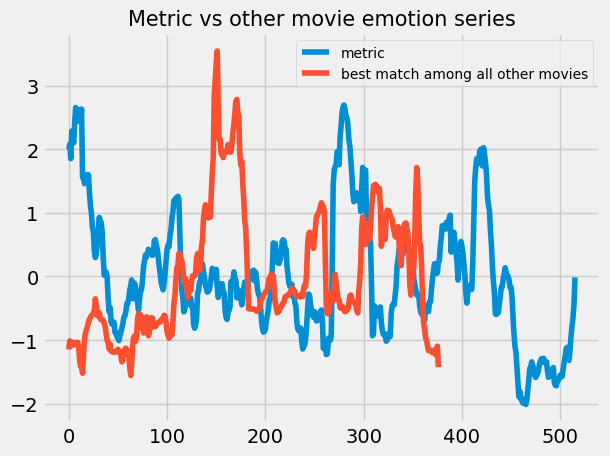

In [12]:
plt.plot(z1, label='metric')
plt.plot(zscore(np.array(cur_emo[cur_emo.filename == 'W_BigBuckBunny13.csv']['score'])), label='best match among all other movies')
plt.legend(prop={'size':10})
plt.title("Metric vs other movie emotion series", size=15)

For Metric 5: we monitor each parcels/regions separately 

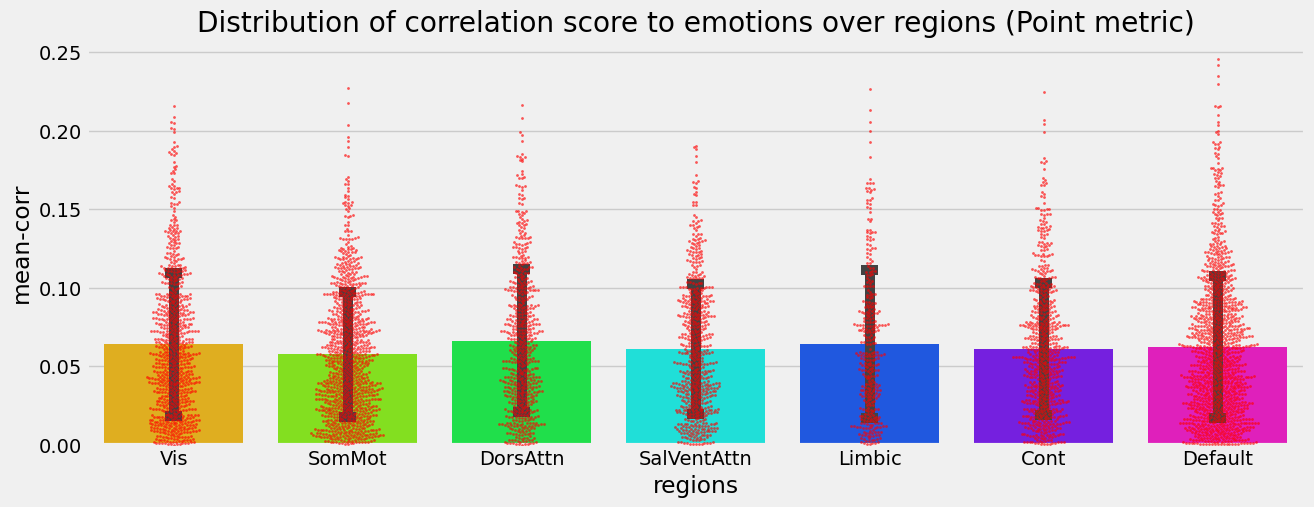

In [13]:
partial_region = load('./resources/region400yeo7.pkl')
partial_region = list(partial_region.values())

concat_region = np.concatenate([partial_region * scores2.shape[1]])
corr_score = {'regions': concat_region, 'mean-corr': np.abs(scores2.flatten())}

pal = sns.color_palette('hsv', len(networks))
plt.figure(figsize=(14,5))
sns.barplot(x="regions", y="mean-corr", data=corr_score, capsize=.1, errorbar="sd", palette=pal)
sns.swarmplot(x="regions", y="mean-corr", data=corr_score, color="r", alpha=.65, size=2)
plt.title("Distribution of correlation score to emotions over regions (Point metric)")
plt.show()

Direct series visualization comparison (check)

In [14]:
indextosee = []
n = np.prod(scores.shape[1:]) - 1
for m in range(nb_metric):
    indextosee.append(list(scores[m].flatten().argsort()[[0,n-1,n]]))

indextosee = np.stack(indextosee)

Text(0.5, 0.98, 'Examples of correlations metric vs emotion')

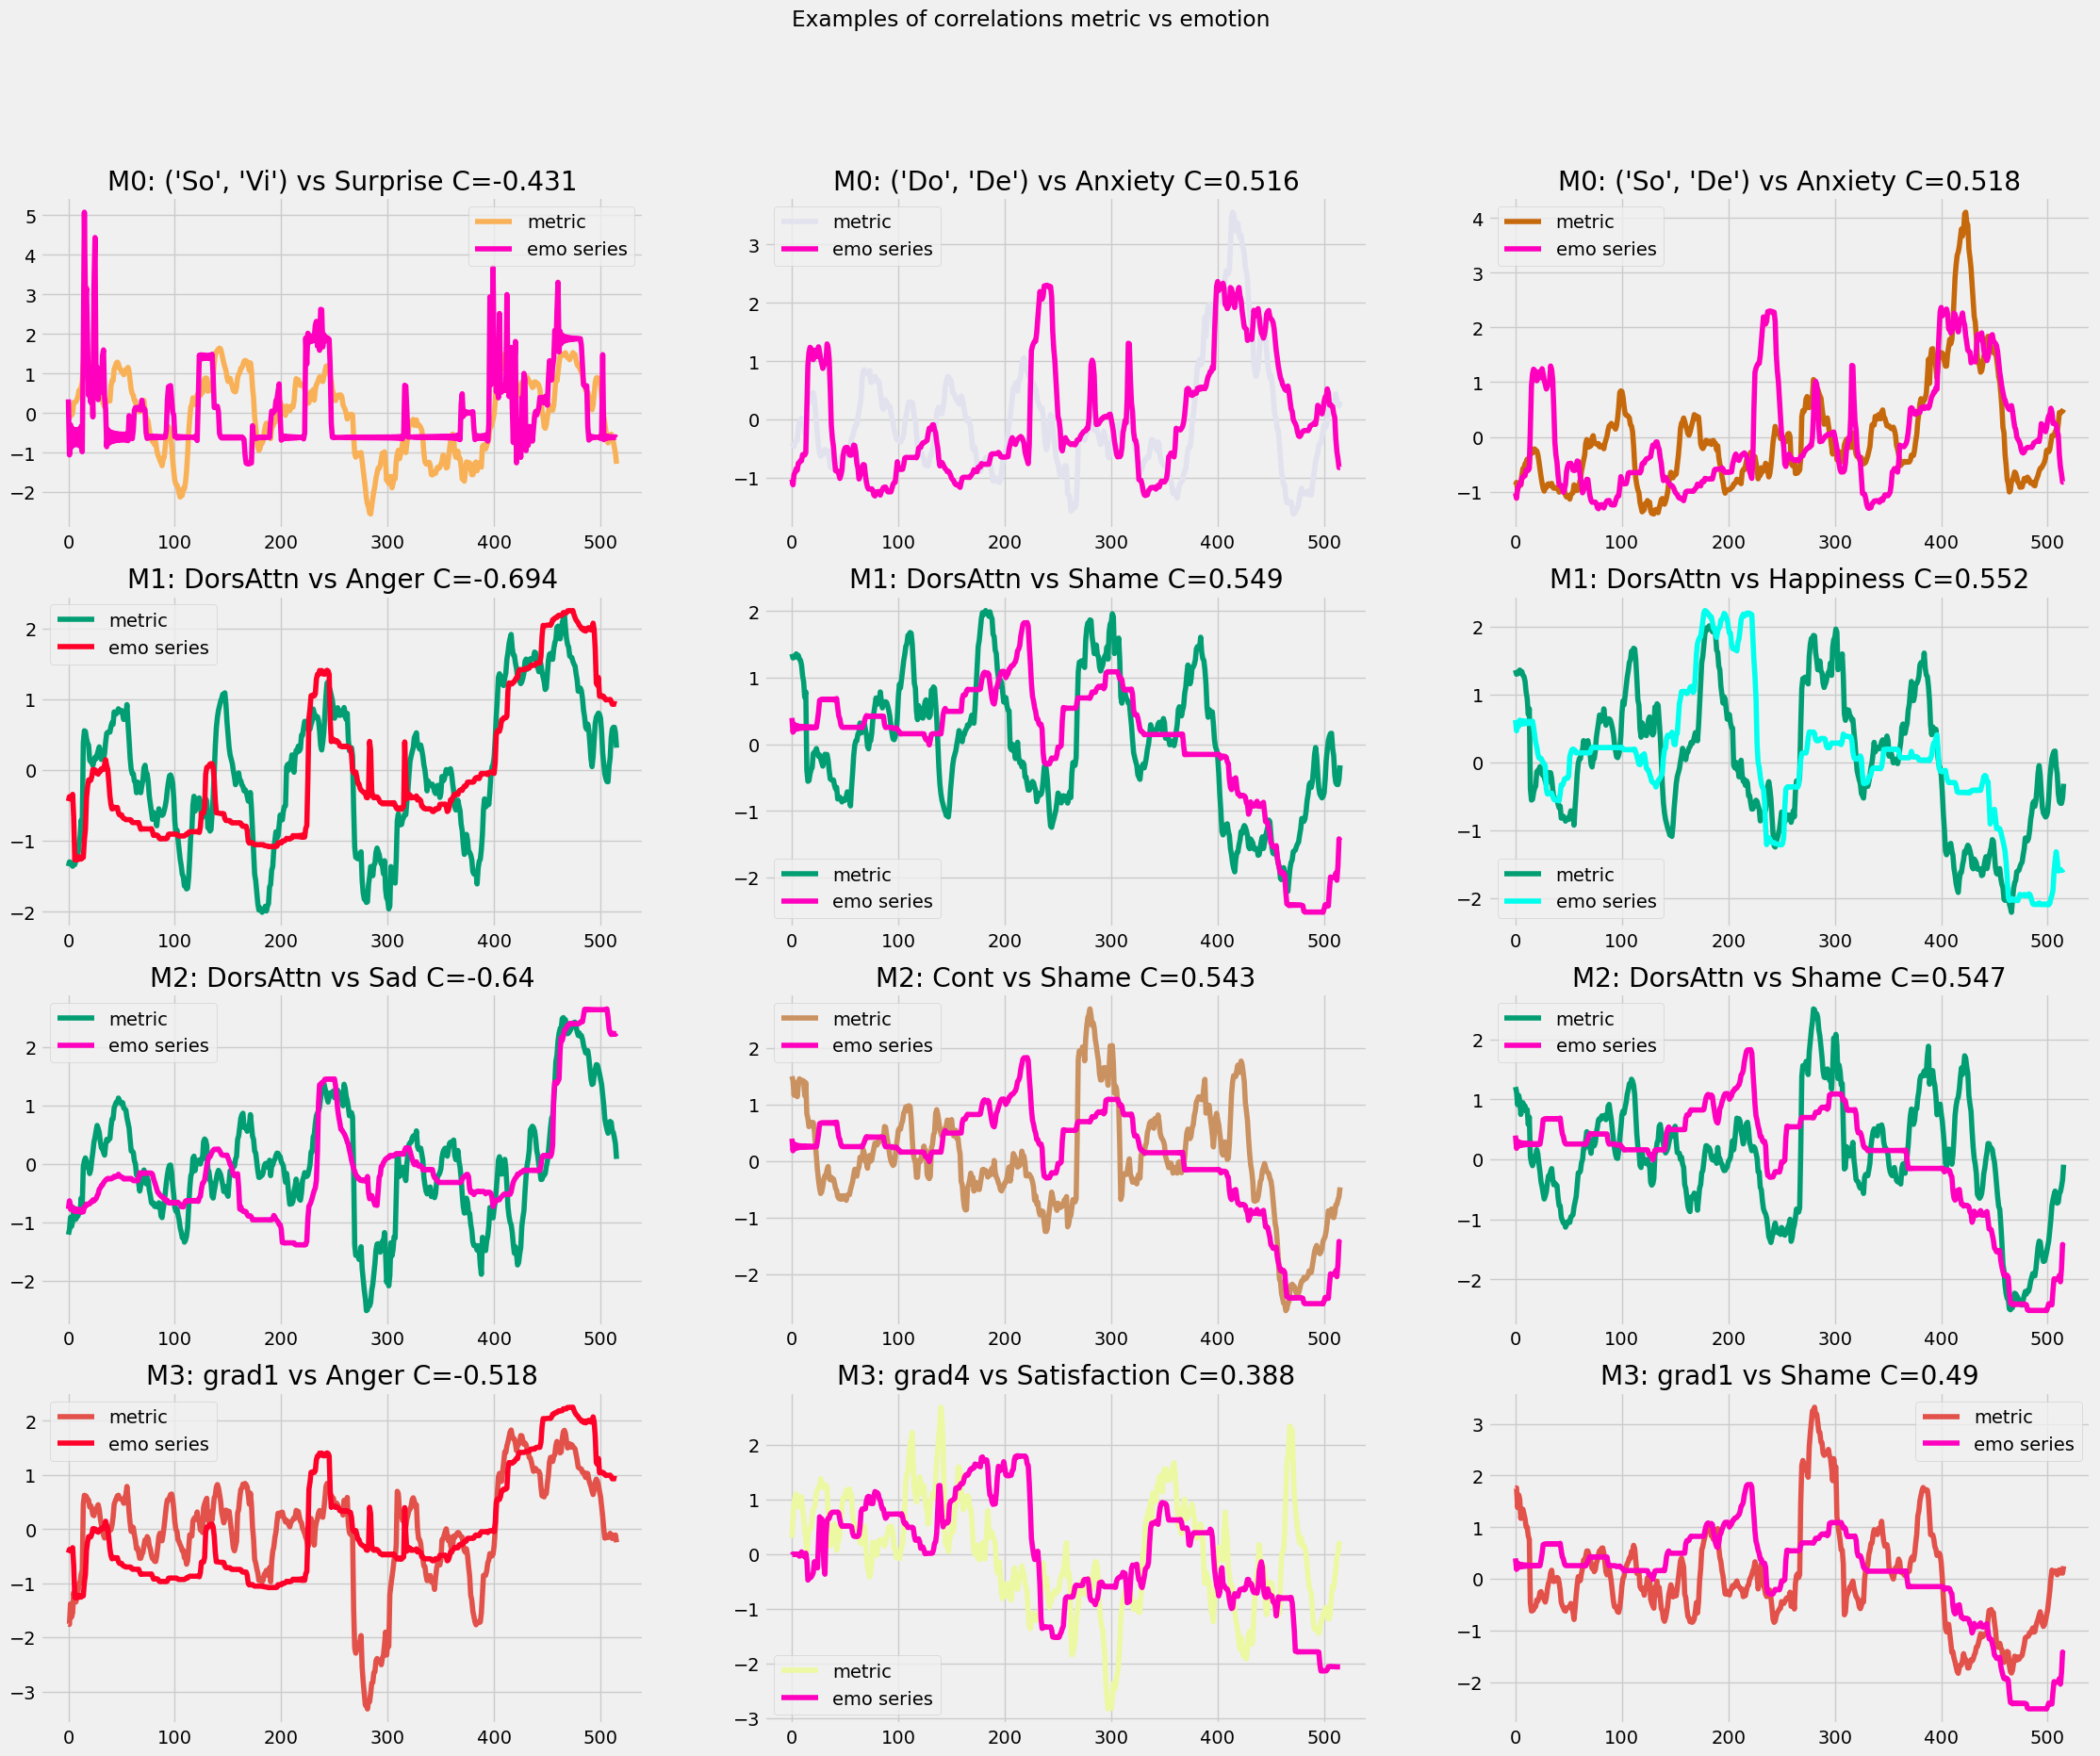

In [30]:
fig, ax = plt.subplots(4,3, figsize=(25,20))

# compute the index we want to see 
# (we take the 2 largest positive corr and 1 most negative corr for each metric)
indextosee = []
n = np.prod(scores.shape[1:]) - 1
for m in range(nb_metric):
    indextosee.append(list(scores[m].flatten().argsort()[[0,n-1,n]]))

indextosee = np.stack(indextosee)

cmEmo     = plt.get_cmap('gist_rainbow')
colorsEmo = [cmEmo(1.*i/nb) for i in range(13)]
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)

for m in range(nb_metric):
    
    if m in [1,2]:
        colors = my_cmap.colors
    else:
        cm     = plt.get_cmap(PALETTES[m])
        colors = [cm(1.*i/nb) for i in range(7)]
    for j in range(3):
        idx = indextosee[m][j]
        a,b = idx//13, idx%13

        if m == 0:
            p1,p2 = pairs[a]
            y  = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                            for t in range(len(G_movie))])
            label = p1[:2],p2[:2]                          
        elif m == 1:
            y  = network_variance(G_movie, networks[a], grad_idx)
            label = networks[a]
        elif m == 2:
            y  = np.asarray([network_volume(G_movie[t], networks[a])
                    for t in range(len(G_movie))])
            label = networks[a]
        else:
            y  = varM[:,a]
            label = "grad{}".format(a)
        
        z1 = zscore(y)
        # z1 = low_pass(z1, ks=40)
        emo_series = np.array(emo_df[emo_df.item==select[b]]['score'])
        smoothened = overlap_add(emo_series, smfactor)
        z2   = zscore(smoothened[:z1.shape[0]])
        corr = correlation_search(z1,z2, 0, 1)[0]

        if corr < 0:
            ax[m,j].plot(-z1, label='metric', color=colors[a])
            ax[m,j].plot(z2, label='emo series', color=colorsEmo[b])
        else:
            ax[m,j].plot(z1, label='metric', color=colors[a])
            ax[m,j].plot(z2, label='emo series', color=colorsEmo[b])
            

        ax[m,j].set_title("M{}: {} vs {} C={}".format(m,label,select[b],np.round(corr,3)))
        ax[m,j].legend()
plt.suptitle('Examples of correlations metric vs emotion')

In [ ]:
# # Uncomment for: Sanity Check of Eigenvector explained variances
# plot_eigenvector_importance(g_movie)
# plot_eigenvector_importance(g_rest)

#### Correlation brain maps with 400 parcellations

/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


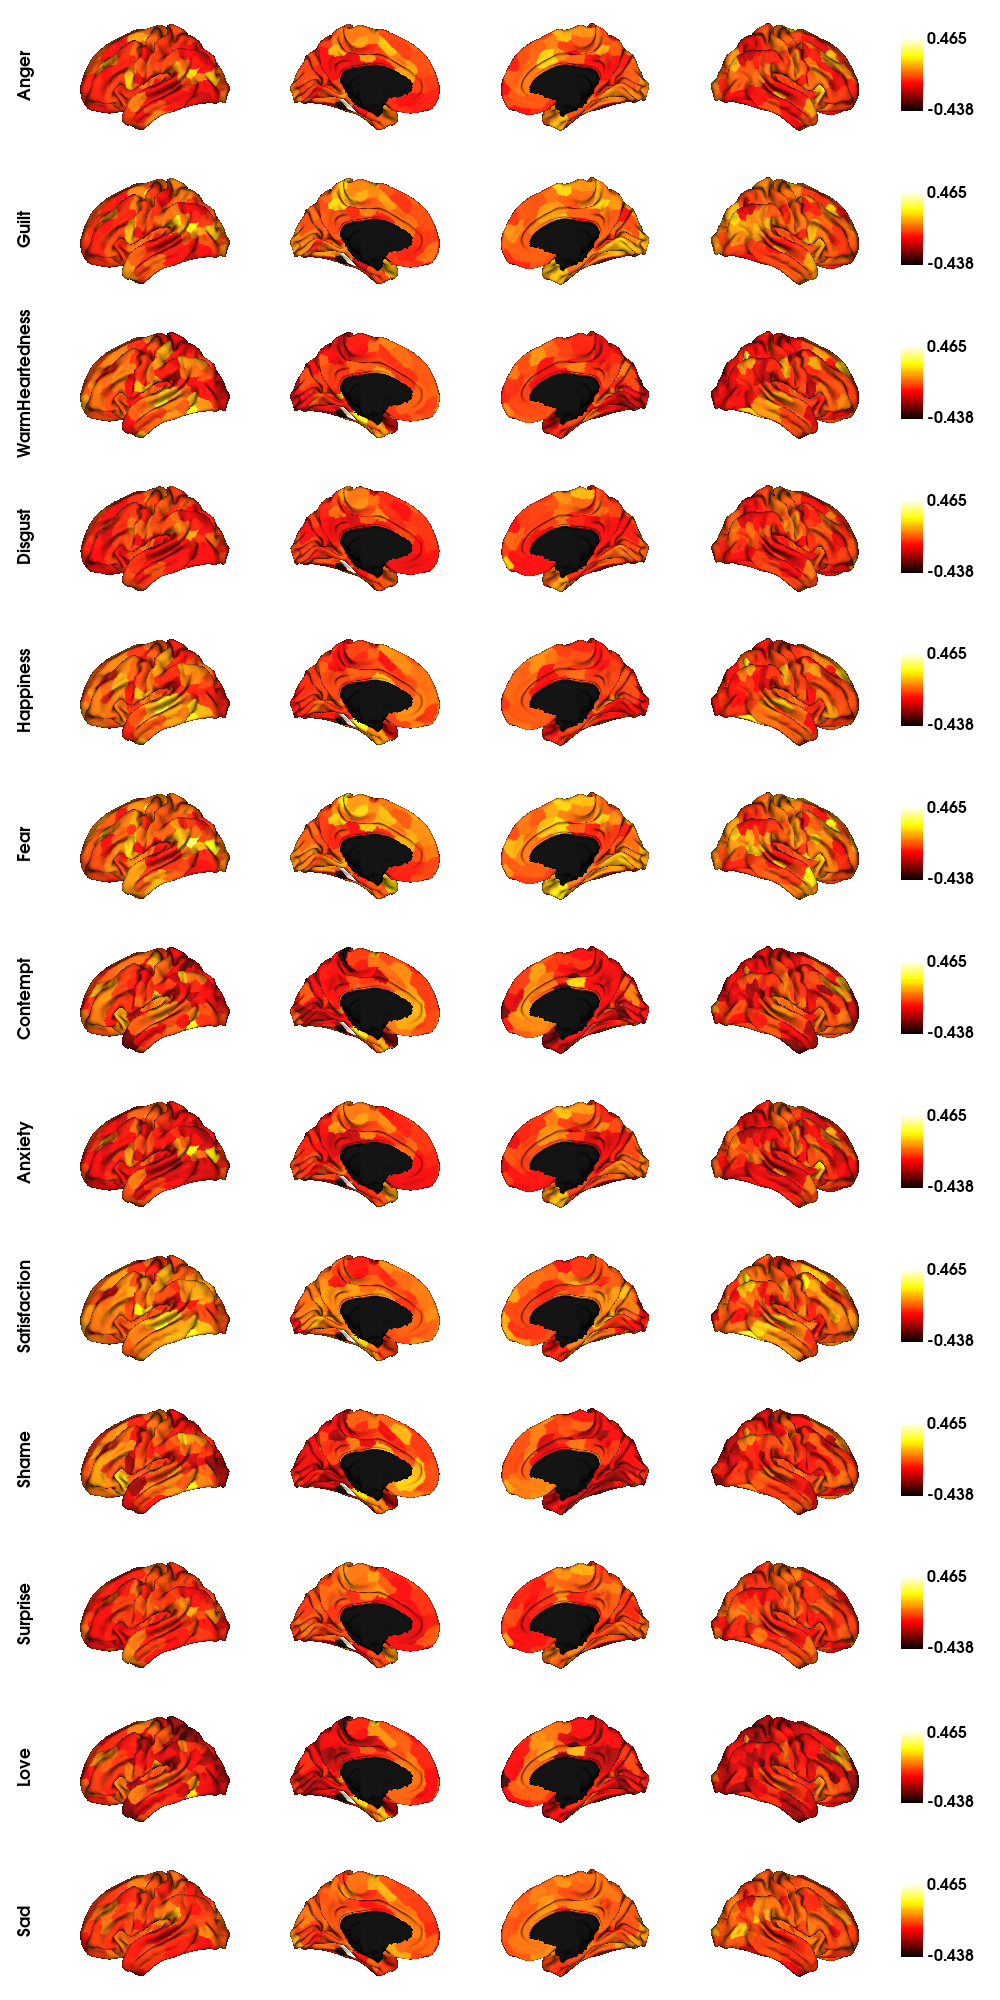

In [126]:
# For a single movie: plots correlation of parcels versus emotions series
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

gs   = deepcopy(scores2.T)

grad = [None] * len(select)
for k in range(gs.shape[0]):
    # map the gradient to the parcels
    gs[k][0]   = gs.min()
    gs[k][1]   = gs.max()
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 2000), cmap='hot',
                 color_bar=True, label_text=select, zoom=1.25, embed_nb=True, interactive=False,
                 transparent_bg=False)


#### Visualization of correlation between metrics and actual movie with emotion series on the side
Details : Look at on correlation metric strong correlation, 2d joint plot moving over time (with some highlights) versus  movie emotions timeseries.
We choose here:
- Emotion : Anger
- Network : Dorsal Attention
- Metric  : Volume Change

In [3]:
# Compute Metric series
tmp_emo = 'Anger'
net     = 'DorsAttn'

ym  = np.asarray([network_volume(G_movie[t], net) 
                    for t in range(len(G_movie))])

# Find Emotion series
emo_series = np.array(emo_df[emo_df.item==tmp_emo]['score'])
smoothened = overlap_add(emo_series, 1)
ye   = zscore(smoothened[:ym.shape[0]])

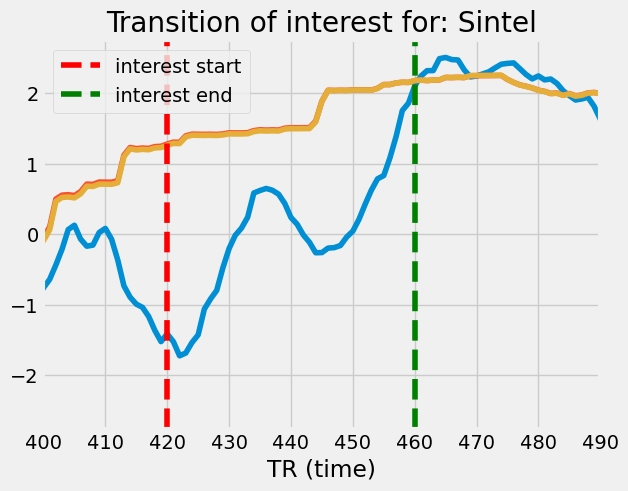

In [12]:
# We want to extract a quick snippet of emotion/metric and watch the corresponding video snippet
plt.plot(zscore(-ym))
# plt.plot(-ym)
plt.plot(ye)
plt.plot(zscore(smoothened))
plt.xlim(400,490)
plt.title('Transition of interest for: {}'.format(moviename))
plt.xlabel('TR (time)')
# We select our snippet to be showing 1 sharp transition, i.e from TR 220 to TR 235 which would give us 15 * TR seconds of movies
moviestart = TR * 420
movieend   = TR * 460
plt.axvline(x=420, linestyle='--', label='interest start', color='r')
plt.axvline(x=460, linestyle='--', label='interest end', color='g')
plt.legend()

In [13]:
fps = 24
start_idx = int(moviestart * fps)
end_idx   = int(movieend * fps)

frames = video2img('./zeal/Sintel_zeal_Surprise.mp4', start_idx=start_idx, end_idx=end_idx)

Display FPS is: 24.0


In [115]:
# Generate the corresponding joint plot video
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)
for j in tqdm(range(len(G_movie))):
    frame  = j
    fig,ax = plt.subplots()
    for idx,net in enumerate(networks):
        if net == 'DorsAttn':
            ax.scatter(G_movie[frame,index2region[net],0], G_movie[frame,index2region[net],1], 
            color=my_cmap.colors[idx], alpha=1, label=net)

            C1 = G_movie[frame,index2region[net],0].mean()
            C2 = G_movie[frame,index2region[net],1].mean()
            ax.scatter(C1, C2, marker='x', s=100,
            color=my_cmap.colors[idx], alpha=1, label=net + '_Centroid')

            R = network_volume(G_movie[frame][:,:2], net)
            circle = plt.Circle((C1, C2), R, color=my_cmap.colors[idx], alpha=0.3)
            ax.add_patch(circle)
        else:
            ax.scatter(G_movie[frame,index2region[net],0], G_movie[frame,index2region[net],1], 
            color=my_cmap.colors[idx], alpha=0.1, label=net)

    legend = ax.legend(loc=1, prop={'size':10})
    for lh in legend.legendHandles: 
        lh.set_alpha(1)
    ax.set_title("Gradient Network Topology")
    ax.set_xlim(-20,25)
    ax.set_ylim(-15,25)
    ax.set_xlabel('G1', fontsize=10)
    ax.set_ylabel('G2', fontsize=10)
    fig.savefig("./media/gradient_plots/{}_{}.jpg".format(moviename,j))
    plt.close("all")

100%|██████████| 516/516 [00:54<00:00,  9.51it/s]


In [116]:
path = "./media/gradient_plots/"

# reorder saved images path
movie_path  = loadimg_in_order([m for m in os.listdir(path)])
movie_array = [cv2.imread(path+'/'+filename) for filename in movie_path]

img2video(movie_array, 10, outpath_name='./media/{}_attention_ws{}.mp4'.format(moviename,40))

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [14]:
# Let's combine the images
nbdup = len(frames)//40
images = []
for i in range(420,460):
    path = './media/gradient_plots/{}_{}.jpg'.format(moviename, i)
    for _ in range(nbdup):
        images.append(cv2.imread(path))

In [15]:
images = np.asarray(images)
frames = np.asarray(frames)

padimages = np.asarray([np.pad(images[i], ((32,32),(0,0),(0,0)) , constant_values=240) for i in range(len(images))])

In [16]:
merged = compare_videos(frames[:,:,:,::-1], padimages)

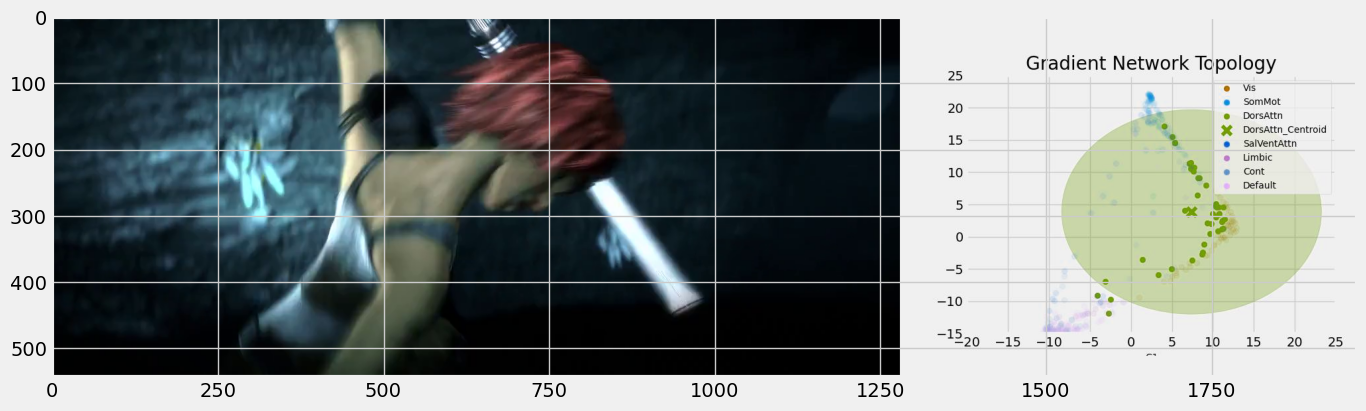

In [17]:
plt.figure(figsize=(15,5))
plt.imshow(merged[0])

In [21]:
img2video(merged[:,:,:,::-1], 24, '24fps.mp4')
# img2video(merged[:,:,:,::-1], 72,' 72fps.mp4')

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


: 

#### Permutation Testing

In [35]:
idxa = 5
idxb = 11

other_df = full_df[full_df.filename != 'W_Sintel13.csv']
order2 = list(other_df.filename.unique())
np.random.shuffle(order2)

concat_other  = np.array(other_df[other_df.item == select[idxb]]['score'])
concat_other2 = np.concatenate([other_df[(other_df.item == select[idxb]) & 
                            (other_df.filename == o)].score for o in order2])

In [36]:
# Obtained sample correlation
a = np.abs(G_movie[:,index2region[regions[idxa]]]).std(axis=1)[:,grad_idx]
b = np.array(emo_df[emo_df.item==select[idxb]]['score'])
b = overlap_add(b, 1)
cur,_,_ = correlation_search(zscore(a), zscore(b[:len(a)]), 0, 1)

In [18]:
discrete = []
for o in order2:
    f = other_df[(other_df.item == select[idxb]) & (other_df.filename == o)].score
    f = overlap_add(f, 1)
    m = min(len(f), len(a))
    corr,_,_ = correlation_search(zscore(a)[:m], zscore(f[:m]), 0, 1)
    discrete.append(corr)

In [40]:
# from mlxtend.evaluate import permutation_test
# permutation_test(a , c, method='approximate', num_rounds=10000, func=lambda x,y: np.corrcoef(x,y)[1][0], seed=0)

# another order of emotions series
null_distrib3 = []
for i in range(len(concat_other2) - len(a)):
    e = concat_other2[i:i+len(a)]
    e = overlap_add(e, 1)
    a, e = zscore(a), zscore(e)
    corr, _,_ = correlation_search(a,e, 0, 1)
    null_distrib3.append(corr)

# default order of emotions series
null_distrib2 = []
for i in range(len(concat_other) - len(a)):
    d = concat_other[i:i+len(a)]
    d = overlap_add(d, 1)
    a, d = zscore(a), zscore(d)
    corr, _,_ = correlation_search(a,d, 0, 1)
    null_distrib2.append(corr)

# shuffling gradient metrics series
np.random.seed(10)
nb_shuffle = 10000
samples = np.zeros((nb_shuffle, len(a)))
for i in range(nb_shuffle):
    ashuffle = deepcopy(a)
    np.random.shuffle(ashuffle)
    samples[i] = ashuffle

c = b[:a.shape[0]]

null_distrib = []
for i in range(len(samples)):
    null_distrib.append(correlation_search(samples[i], c, 0, 1)[0])


Might not be best permutation test as can be seen here in the another movie we obtain basically the same correlation strength, a simple explanation is that the movies (for that specific emotion) themselves as STRONGLY correlated which is what we saw in the explore part notebook 001 (in this plot we still need to know exactly which movie was correlated with it). Careful to always to this plot to verify.

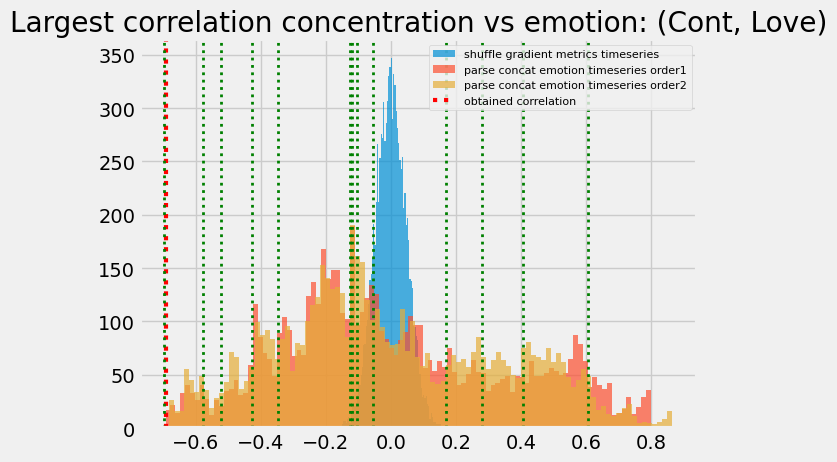

In [50]:
plt.hist(null_distrib, bins=100, alpha=0.7, label="shuffle gradient metrics timeseries")
plt.hist(null_distrib2, bins=100, alpha=0.7, label="parse concat emotion timeseries order1")
plt.hist(null_distrib3, bins=100, alpha=0.7, label="parse concat emotion timeseries order2")
plt.axvline(x=cur, c='r', label='obtained correlation', linestyle='dotted', linewidth=3)
for k in range(len(discrete)):
    plt.axvline(x=discrete[k], c='g', linestyle='dotted', linewidth=2)
plt.title("Largest correlation concentration vs emotion: ({}, {})".format(regions[idxa],select[idxb]))
plt.legend(loc=1, prop={'size':8})